 ## Brain tumor classification (Glioma, Meningioma, Pituitary, No tumor)
**Author:** Soulaimane Rahmoune


This notebook walks through a step-by-step pipeline for classifying brain MRI slices into four categories—glioma tumor, meningioma tumor, no tumor, and pituitary tumor.




Environment & Dependencies
**Runtime:** Google Colab with NVIDIA Tesla T4 GPU (16 GB GPU RAM).  
**Software:** Python 3.x, TensorFlow 2.6.2, Keras (tf.keras)  
**Hardware (Colab instance):** CPU: Intel Xeon, RAM: ~25 GB  ```

### imports

In [1]:
# Standard library
import os
import random
from collections import defaultdict

# Numerical & plotting
import numpy as np
import matplotlib.pyplot as plt

# Image I/O
from skimage.io import imread, imsave, imshow

# Scikit-learn utilities
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.utils import class_weight

# TensorFlow & Keras core
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# Pretrained architectures
from tensorflow.keras.applications import (
    MobileNet,
    EfficientNetB0,
    DenseNet121,
    VGG16,
    ConvNeXtTiny
)

# Visualization helper
import visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 20.5 MB/s eta 0:00:00


#Dataset Overview and Visualization Utilities for Training



In [2]:
def plot_graphs(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.history['accuracy']))

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [3]:
color_map = defaultdict(dict)
color_map[InputLayer]['fill'] = 'cornflowerblue'
color_map[Dropout]['fill'] = 'darkcyan'
color_map[Conv2D]['fill'] = 'skyblue'
color_map[MaxPooling2D]['fill'] = 'blue'
color_map[BatchNormalization]['fill'] = 'lightblue'
color_map[Flatten]['fill'] = 'royalblue'
color_map[Dense]['fill'] = 'darkblue'

In [4]:
uploaded = files.upload()                # click the “Choose Files” button

Saving brain_tumor_data.zip to brain_tumor_data.zip


In [5]:
!unzip brain_tumor_data.zip -d /content/

Archive:  brain_tumor_data.zip
   creating: /content/Training_cropped/
   creating: /content/Training_cropped/no_tumor/
  inflating: /content/Training_cropped/no_tumor/image(115).jpg  
  inflating: /content/Training_cropped/no_tumor/image(142).jpg  
  inflating: /content/Training_cropped/no_tumor/image(49).jpg  
  inflating: /content/Training_cropped/no_tumor/image(1).jpg  
  inflating: /content/Training_cropped/no_tumor/image(284).jpg  
  inflating: /content/Training_cropped/no_tumor/image(154).jpg  
  inflating: /content/Training_cropped/no_tumor/image(292).jpg  
  inflating: /content/Training_cropped/no_tumor/image(103).jpg  
  inflating: /content/Training_cropped/no_tumor/image(197).jpg  
  inflating: /content/Training_cropped/no_tumor/image(178).jpg  
  inflating: /content/Training_cropped/no_tumor/image(73).jpg  
  inflating: /content/Training_cropped/no_tumor/image(251).jpg  
  inflating: /content/Training_cropped/no_tumor/image(314).jpg  
  inflating: /content/Training_cropped/

In [6]:
%cd /content/

print('There are: \n')

for dirname, _, _ in os.walk('Training_cropped/'):
    if dirname != 'Training_cropped/':
        print('     ',len(os.listdir(dirname)), 'images in', dirname)

for dirname, _, _ in os.walk('Testing_cropped/'):
    if dirname != 'Testing_cropped/':
        print('     ', len(os.listdir(dirname)), 'images in', dirname)

/content
There are: 

      822 images in Training_cropped/meningioma_tumor
      827 images in Training_cropped/pituitary_tumor
      826 images in Training_cropped/glioma_tumor
      395 images in Training_cropped/no_tumor
      115 images in Testing_cropped/meningioma_tumor
      74 images in Testing_cropped/pituitary_tumor
      100 images in Testing_cropped/glioma_tumor
      105 images in Testing_cropped/no_tumor


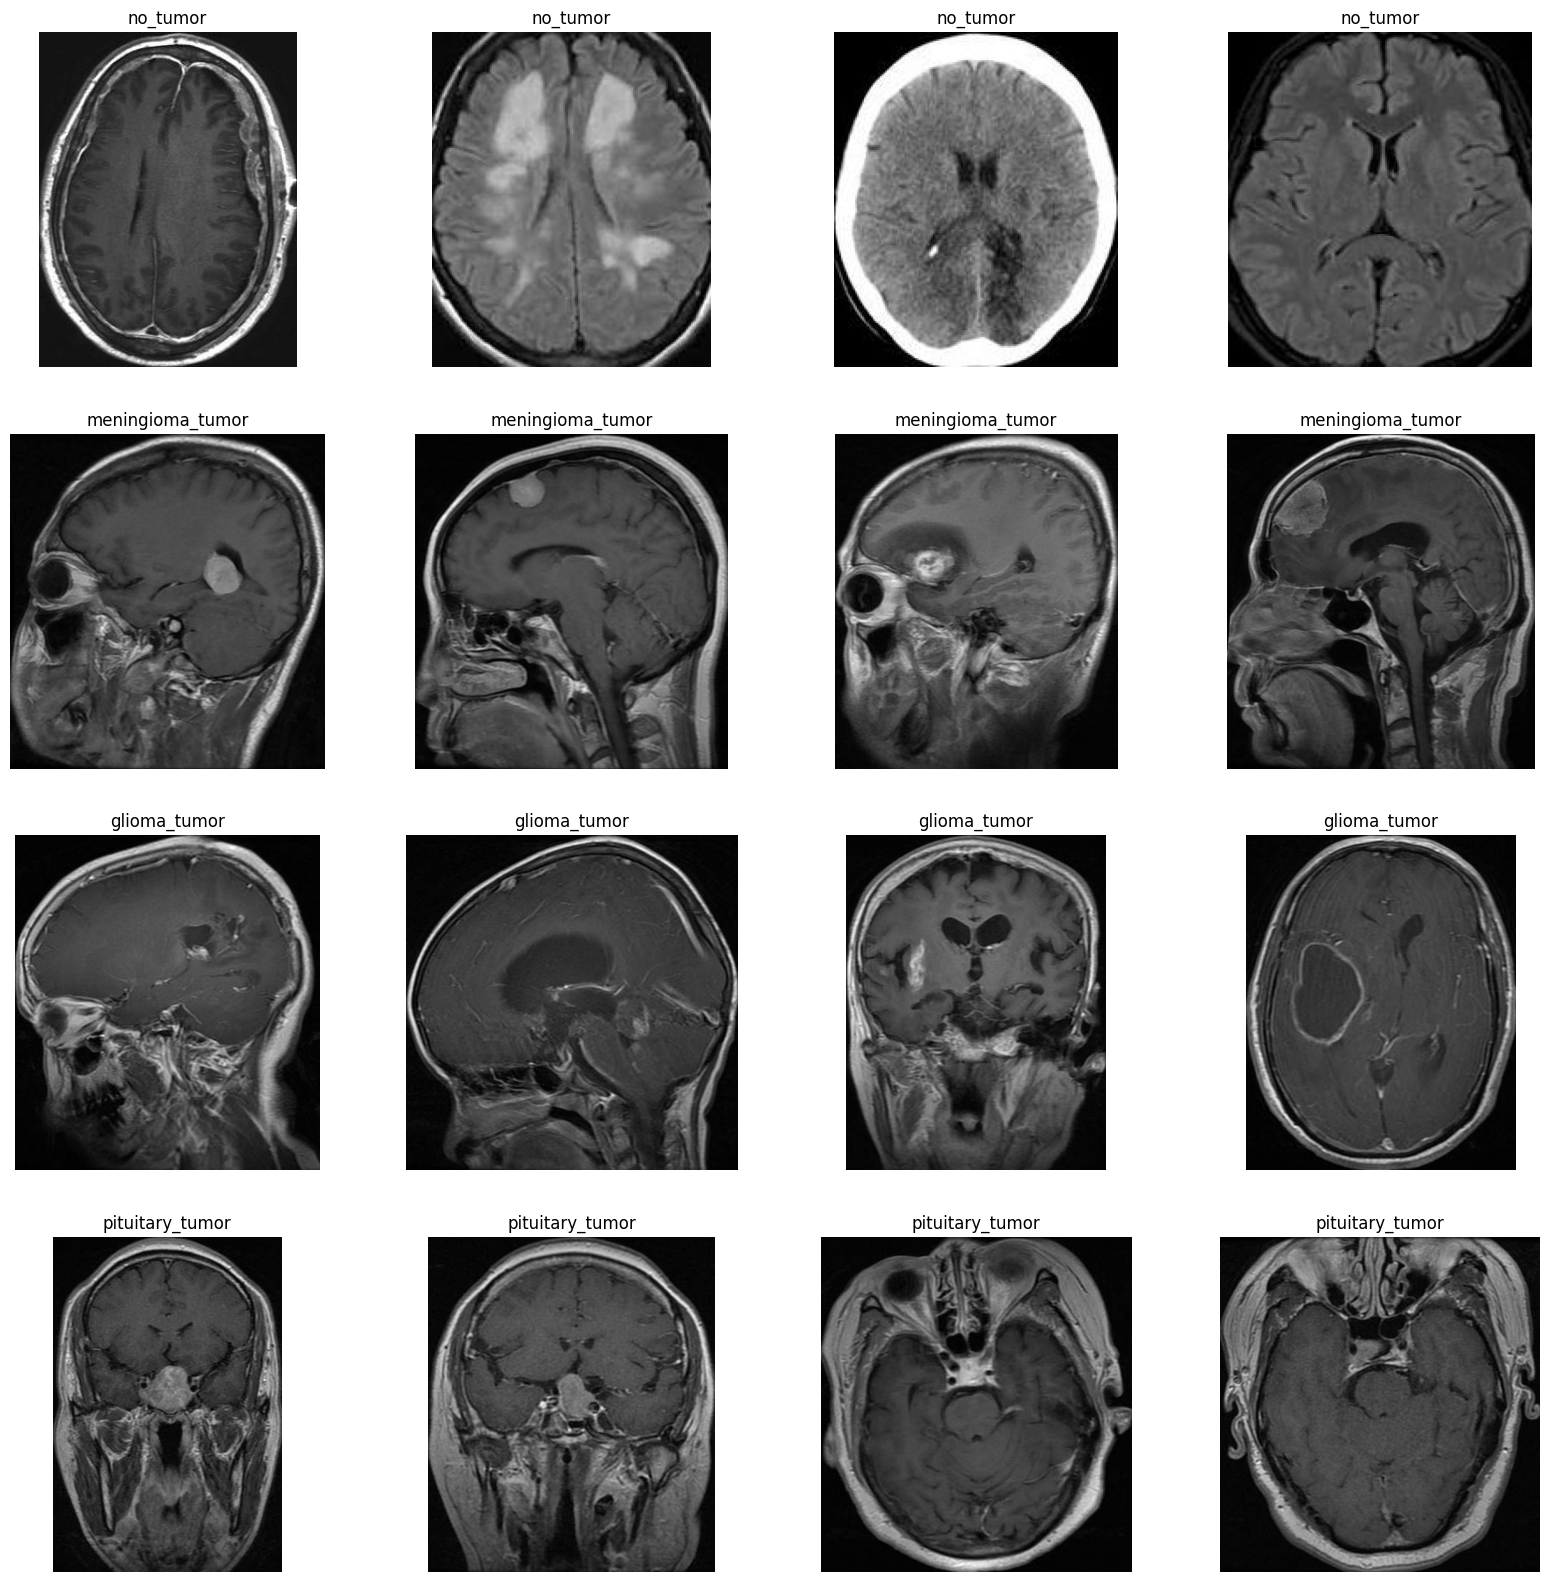

In [7]:
# 1) List all filenames in each class directory
no_tumor = os.listdir('Training_cropped/no_tumor/')
meningioma_tumor = os.listdir('Training_cropped/meningioma_tumor/')
glioma_tumor = os.listdir('Training_cropped/glioma_tumor/')
pituitary_tumor = os.listdir('Training_cropped/pituitary_tumor/')

# 2) Set up a large figure for a 4×4 grid of subplots
plt.figure(figsize=(20, 20))

posplot = 1  # tracks the current subplot position (1–16)

# 3) Generate 28 random indices (but we’ll only plot the first 16)
random_indices = [random.randint(0, len(no_tumor) - 1) for _ in range(28)]

for idx in random_indices:
    # Determine which class to plot based on subplot position
    if posplot <= 4:
        # First row: no_tumor images
        cls_name = 'no_tumor'
        img_list = no_tumor
    elif posplot <= 8:
        # Second row: meningioma_tumor images
        cls_name = 'meningioma_tumor'
        img_list = meningioma_tumor
    elif posplot <= 12:
        # Third row: glioma_tumor images
        cls_name = 'glioma_tumor'
        img_list = glioma_tumor
    else:
        # Fourth row: pituitary_tumor images
        cls_name = 'pituitary_tumor'
        img_list = pituitary_tumor

    # 4) Create the subplot at the current grid position
    plt.subplot(4, 4, posplot)
    plt.title(cls_name.replace('_', ' ').title())  # nicer title
    # 5) Read and display the randomly chosen image
    img_path = f'Training_cropped/{cls_name}/{img_list[idx]}'
    plt.imshow(imread(img_path), cmap='gray')
    plt.axis('off')  # hide axes for clarity

    posplot += 1  # move to next subplot slot

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 181,
                                   validation_split = 0.138)


test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Create training and validation generators from the same directory, using the split defined above
training_dataset = train_datagen.flow_from_directory(
    'Training_cropped/',      # path to the training images
    target_size=(128,128),    # resize all images to 128×128 pixels
    color_mode="rgb",         # load images as 3-channel RGB
    subset="training",        # use the 'training' portion of the split
    class_mode='categorical', # one-hot encode the labels for 4 classes
    shuffle=True              # shuffle data each epoch for better mixing
)

validation_dataset = train_datagen.flow_from_directory(
    'Training_cropped/',      # same folder, but now using the validation split
    target_size=(128,128),
    color_mode="rgb",
    subset="validation",      # use the 'validation' portion of the split
    class_mode='categorical',
    shuffle=True              # can shuffle validation if desired (order doesn’t matter much)
)

# Create a generator for the held-out test set (no shuffling to preserve order)
testing_dataset = test_datagen.flow_from_directory(
    'Testing_cropped/',       # path to the test images
    target_size=(128,128),
    color_mode="rgb",
    class_mode='categorical', # same one-hot labels
    shuffle=False             # do NOT shuffle so we can align predictions with file order
)


Found 2476 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 394 images belonging to 4 classes.



76% training, 12% validation and 12% testing

In [10]:
# Define human-readable class names in the same order as the one-hot encoding
target_names = [
    'glioma tumor',        # class index 0
    'meningioma tumor',    # class index 1
    'no tumor',            # class index 2
    'pituitary tumor'      # class index 3
]


In [11]:
# 1) Fetch one batch of images and labels from the training generator
imgs, labels = next(training_dataset)

# 2) Print the shapes to confirm batch dimensions
#    imgs.shape → (batch_size, 128, 128, 3)
#    labels.shape → (batch_size, 4) for one-hot encoded labels
print("Batch shapes:", imgs.shape, labels.shape)

# 3) Decode the one-hot labels back to integer class indices and count occurrences
unique_indices, counts = np.unique(np.argmax(labels, axis=1), return_counts=True)
print("Unique labels in this batch:", unique_indices, counts)
#    Example output: ([0, 1, 2, 3], [ 8, 10,  4, 10])
#    Means: class 0 appears 8×, class 1 appears 10×, etc.



Batch shapes: (32, 128, 128, 3) (32, 4)
Unique labels in this batch: (array([0, 1, 2, 3]), array([ 8,  8,  2, 14]))


# Codebasics tutorial inspired model

In [12]:
# 1) Define a simple Sequential CNN classifier
classifier = Sequential([
    # First convolutional block
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    # Second convolutional block
    Conv2D(32, (3,3), activation='relu'),
    # Down‐sample spatial dimensions by a factor of 6×6
    MaxPooling2D((6,6)),
    # Flatten the feature maps into a vector
    Flatten(),
    # Fully connected hidden layer with 128 units
    Dense(128, activation='relu'),
    # Output layer with 4 units (one per class) and softmax activation
    Dense(4, activation='softmax'),
])

# 2) Compile the model: use Adam optimizer, categorical crossentropy loss,
#    and track accuracy
classifier.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

# 3) Print a summary of the layer architecture & parameter counts
classifier.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,648,612 (6.29 MB)

 Trainable params: 1,648,612 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Visualize the CNN architecture as a layered diagram
# - `classifier` is your Sequential model defined above
# - `legend=True` shows a key mapping layer types to colors
# - `color_map=color_map` applies your custom color mapping for clarity
visualkeras.layered_view(
    classifier,
    legend=True,
    color_map=color_map
)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


## Fitting the model

In [ ]:
# 1) Define callbacks to control training:
callbacks = [
    EarlyStopping(
        patience=4,                # stop if val_accuracy doesn't improve for 4 epochs
        monitor="val_accuracy",    # monitor validation accuracy
        restore_best_weights=True  # roll back to the best weights after stopping
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',    # reduce LR when val_accuracy plateaus
        factor=0.5,                # LR is multiplied by 0.5 on plateau
        patience=4,                # wait 4 epochs before reducing
        min_delta=0.001,           # need at least 0.1% improvement to reset patience
        mode='auto',
        verbose=1
    )
]

# 2) Train the simple CNN `classifier` for up to 35 epochs
history_classifier = classifier.fit(
    training_dataset,       # training data generator
    epochs=35,              # maximum number of epochs
    validation_data=validation_dataset,  # validation data generator
    callbacks=callbacks     # our EarlyStopping & LR scheduler
)

# 3) Plot the training & validation accuracy/loss curves
plot_graphs(history_classifier)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.3177 - loss: 1.3704 - val_accuracy: 0.4797 - val_loss: 1.1997 - learning_rate: 0.0010
Epoch 2/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4748 - loss: 1.1534 - val_accuracy: 0.4924 - val_loss: 1.0564 - learning_rate: 0.0010
Epoch 3/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.6138 - loss: 0.9430 - val_accuracy: 0.5127 - val_loss: 1.1279 - learning_rate: 0.0010
Epoch 4/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.6087 - loss: 0.9360 - val_accuracy: 0.5127 - val_loss: 1.0282 - learning_rate: 0.0010
Epoch 5/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6313 - loss: 0.8644 - val_accuracy: 0.5787 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 6/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6803 - loss: 0.7904 - val_accuracy: 0.5863 - val_loss: 0.9181 - learning_rate: 0.0010
Epoch 7/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.6713 - loss: 0.7628 - 

## Evaluating the model

In [ ]:
classifier.evaluate(testing_dataset, verbose=1)
predictions = classifier.predict(testing_dataset, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3900 - loss: 3.2042
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


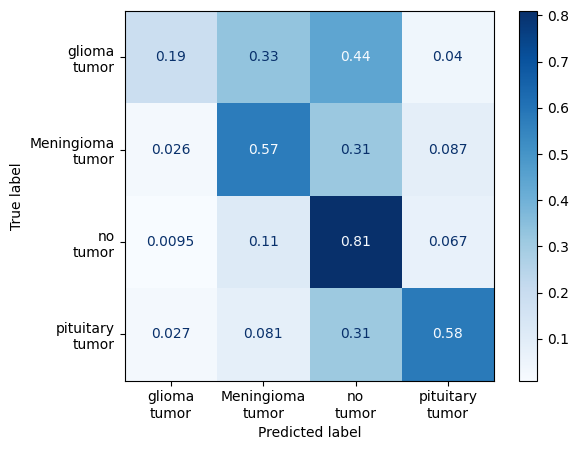

In [ ]:
pred = np.argmax(predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

In [ ]:
print(classification_report(testing_dataset.labels, pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.76      0.19      0.30       100
meningioma tumor       0.56      0.57      0.57       115
        no tumor       0.45      0.81      0.58       105
 pituitary tumor       0.67      0.58      0.62        74

        accuracy                           0.54       394
       macro avg       0.61      0.54      0.52       394
    weighted avg       0.60      0.54      0.51       394



#Improved model

In [19]:
# 1) Define a deeper CNN from scratch with input rescaling
improved = models.Sequential([
    # Input layer: expect 128×128 grayscale images, then normalize pixels to [0,1]
    Input(shape=(128, 128, 1)),
    Rescaling(1./255),

    # Block 1: two 3×3 Conv layers with 32 filters → batchnorm → 2×2 max-pool
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 2: double the filters to 64
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 3: double again to 128 filters
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 4: final conv block with 256 filters
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Classification head:
    # - GlobalAveragePooling2D reduces each feature map to a single value
    # - Dropout for regularization
    # - Dense layer with L2 weight decay
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    Dropout(0.5),
    # Final softmax layer for 4-class output
    Dense(4, activation='softmax'),
])

# 2) Compile the model with Adam optimizer and categorical crossentropy
improved.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Print the summary of layers and parameters
improved.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             

 Total params: 1,242,340 (4.74 MB)

 Trainable params: 1,240,420 (4.73 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [20]:
visualkeras.layered_view(improved, legend=True, color_map=color_map)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
# 1) Define your callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=8,
    monitor="val_accuracy",
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=2,
    min_delta=0.001,
    mode='auto',
    verbose=1
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_accuracy"
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir="logs/"
)

# 2) Combine them into a single list
callbacks = [
    early_stopping,
    reduce_lr,
    model_checkpoint,
    tensorboard_cb
]

# 3) Pass into .fit()
history_improved = improved.fit(
    training_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

# 4) Plot your training curves
plot_graphs(history_improved)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4487 - loss: 1.4262

78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.4495 - loss: 1.4241 - val_accuracy: 0.2868 - val_loss: 3.9508 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.5915 - loss: 1.0428 - val_accuracy: 0.2868 - val_loss: 7.8698 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6982 - loss: 0.7922

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6983 - loss: 0.7922 - val_accuracy: 0.2893 - val_loss: 4.7915 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.7239 - loss: 0.7197 - val_accuracy: 0.2893 - val_loss: 5.9578 - learning_rate: 0.0010
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7244 - loss: 0.7138
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.7246 - loss: 0.7134 - val_accuracy: 0.2893 - val_loss: 7.4409 - learning_rate: 0.0010
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7860 - loss: 0.5793 - val_accuracy: 0.2893 - val_loss: 8.0285 - learning_rate: 3.0000e-04
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8033 - loss: 0.5310

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8033 - loss: 0.5311 - val_accuracy: 0.3020 - val_loss: 7.8040 - learning_rate: 3.0000e-04
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7883 - loss: 0.5425

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.7885 - loss: 0.5422 - val_accuracy: 0.4036 - val_loss: 2.6055 - learning_rate: 3.0000e-04
Epoch 9/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8192 - loss: 0.5043 - val_accuracy: 0.1345 - val_loss: 7.1615 - learning_rate: 3.0000e-04
Epoch 10/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8097 - loss: 0.5029

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.8099 - loss: 0.5027 - val_accuracy: 0.5761 - val_loss: 2.4738 - learning_rate: 3.0000e-04
Epoch 11/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.8392 - loss: 0.4382 - val_accuracy: 0.3553 - val_loss: 3.2808 - learning_rate: 3.0000e-04
Epoch 12/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8381 - loss: 0.4483
Epoch 12: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8380 - loss: 0.4486 - val_accuracy: 0.3046 - val_loss: 3.1729 - learning_rate: 3.0000e-04
Epoch 13/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8504 - loss: 0.4090

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8504 - loss: 0.4090 - val_accuracy: 0.5964 - val_loss: 1.1201 - learning_rate: 9.0000e-05
Epoch 14/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.8650 - loss: 0.4028 - val_accuracy: 0.4898 - val_loss: 1.8873 - learning_rate: 9.0000e-05
Epoch 15/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8579 - loss: 0.3836

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8580 - loss: 0.3835 - val_accuracy: 0.7259 - val_loss: 0.7257 - learning_rate: 9.0000e-05
Epoch 16/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8628 - loss: 0.3636 - val_accuracy: 0.5254 - val_loss: 2.1912 - learning_rate: 9.0000e-05
Epoch 17/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8725 - loss: 0.3583
Epoch 17: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8726 - loss: 0.3584 - val_accuracy: 0.6244 - val_loss: 1.1185 - learning_rate: 9.0000e-05
Epoch 18/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8987 - loss: 0.3179

78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.8984 - loss: 0.3183 - val_accuracy: 0.8122 - val_loss: 0.4987 - learning_rate: 2.7000e-05
Epoch 19/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8816 - loss: 0.3162

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8817 - loss: 0.3164 - val_accuracy: 0.8198 - val_loss: 0.4669 - learning_rate: 2.7000e-05
Epoch 20/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8861 - loss: 0.3295

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8862 - loss: 0.3294 - val_accuracy: 0.8376 - val_loss: 0.4440 - learning_rate: 2.7000e-05
Epoch 21/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.8795 - loss: 0.3481 - val_accuracy: 0.7259 - val_loss: 0.8480 - learning_rate: 2.7000e-05
Epoch 22/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8884 - loss: 0.3053
Epoch 22: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8884 - loss: 0.3055 - val_accuracy: 0.8325 - val_loss: 0.4532 - learning_rate: 2.7000e-05
Epoch 23/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9097 - loss: 0.2931 - val_accuracy: 0.8350 - val_loss: 0.4158 - learning_rate: 8.1000e-06
Epoch 24/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8945 - loss: 0.3020

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.8945 - loss: 0.3020 - val_accuracy: 0.8553 - val_loss: 0.4151 - learning_rate: 8.1000e-06
Epoch 25/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8956 - loss: 0.2929

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8956 - loss: 0.2929 - val_accuracy: 0.8604 - val_loss: 0.4152 - learning_rate: 8.1000e-06
Epoch 26/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9032 - loss: 0.3076 - val_accuracy: 0.8325 - val_loss: 0.4243 - learning_rate: 8.1000e-06
Epoch 27/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8917 - loss: 0.3298
Epoch 27: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.8918 - loss: 0.3297 - val_accuracy: 0.8604 - val_loss: 0.3768 - learning_rate: 8.1000e-06
Epoch 28/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9057 - loss: 0.2970 - val_accuracy: 0.8477 - val_loss: 0.4108 - learning_rate: 2.4300e-06
Epoch 29/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8969 - loss: 0.2985
Epoch 29: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8970 - loss: 

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8881 - loss: 0.3174 - val_accuracy: 0.8706 - val_loss: 0.3932 - learning_rate: 7.2900e-07


In [ ]:
improved.evaluate(testing_dataset, verbose=1)
predictions = improved.predict(testing_dataset, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4511 - loss: 4.2425
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


In [ ]:
pred = np.argmax(predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

In [ ]:
print(classification_report(testing_dataset.labels, pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.75      0.18      0.29       100
meningioma tumor       0.72      0.79      0.75       115
        no tumor       0.50      0.90      0.64       105
 pituitary tumor       0.79      0.57      0.66        74

        accuracy                           0.62       394
       macro avg       0.69      0.61      0.59       394
    weighted avg       0.68      0.62      0.59       394



## Adding Class weights

In [17]:
# 1) Compute class weights from your training labels:
y_train = np.array(training_dataset.classes)   # integer labels 0–3
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
# e.g. {0: 1.8, 1: 0.9, 2: 0.8, 3: 1.2}

In [21]:
# 2) Re-compile with label smoothing
improved.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [ ]:
# 3) Add them to .fit( ) call
history_improved = improved.fit(
    training_dataset,
    epochs=35,
    validation_data=validation_dataset,
    callbacks=callbacks,
    class_weight=class_weights,        # ← pay extra attention to glioma
)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - accuracy: 0.7889 - loss: 0.9025 - val_accuracy: 0.2868 - val_loss: 9.1215 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8160 - loss: 0.7611 - val_accuracy: 0.1371 - val_loss: 11.8980 - learning_rate: 0.0010
Epoch 3/30
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8376 - loss: 0.7184
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.8374 - loss: 0.7184 - val_accuracy: 0.1371 - val_loss: 142.6308 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8475 - loss: 0.6766 - val_accuracy: 0.1371 - val_loss: 41.0583 - learning_rate: 3.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8848 - loss: 0.6264
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8848 - loss: 0.

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9176 - loss: 0.5638 - val_accuracy: 0.8756 - val_loss: 0.6093 - learning_rate: 7.2900e-07
Epoch 26/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9194 - loss: 0.5590 - val_accuracy: 0.8731 - val_loss: 0.6103 - learning_rate: 7.2900e-07
Epoch 27/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9050 - loss: 0.5781

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9051 - loss: 0.5781 - val_accuracy: 0.8959 - val_loss: 0.5948 - learning_rate: 7.2900e-07
Epoch 28/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9185 - loss: 0.5639 - val_accuracy: 0.8883 - val_loss: 0.5993 - learning_rate: 7.2900e-07
Epoch 29/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9100 - loss: 0.5756
Epoch 29: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9101 - loss: 0.5754 - val_accuracy: 0.8909 - val_loss: 0.6018 - learning_rate: 7.2900e-07
Epoch 30/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9192 - loss: 0.5519 - val_accuracy: 0.8934 - val_loss: 0.5970 - learning_rate: 2.1870e-07


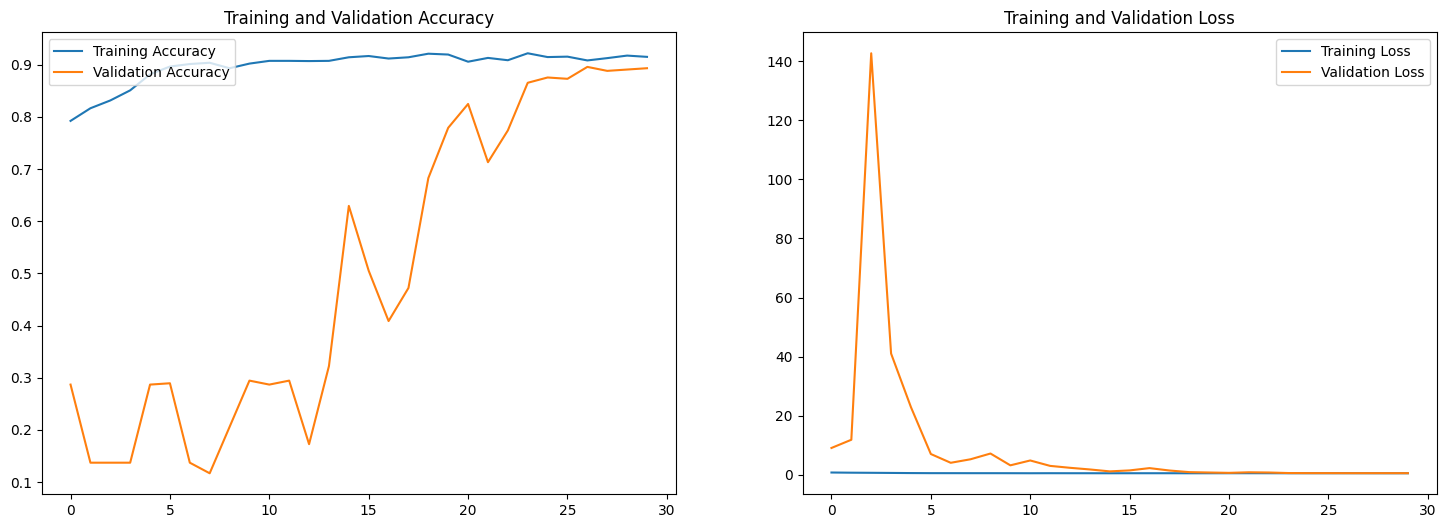

In [ ]:
# 4) Plot your training curves
plot_graphs(history_improved)

In [ ]:
improved.evaluate(testing_dataset, verbose=1)
predictions = improved.predict(testing_dataset, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4908 - loss: 1.6714
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


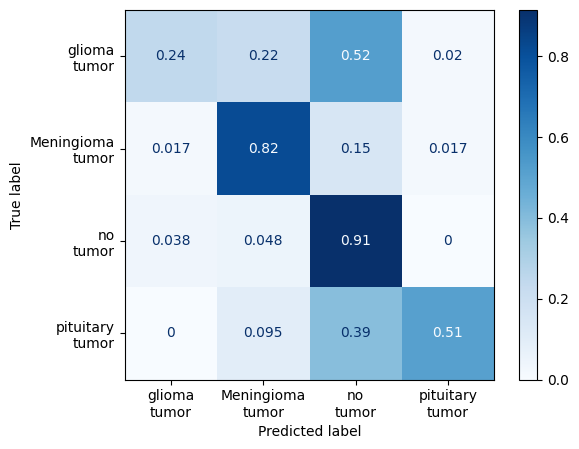

In [ ]:
pred = np.argmax(predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

In [ ]:
print(classification_report(testing_dataset.labels, pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.80      0.24      0.37       100
meningioma tumor       0.73      0.82      0.77       115
        no tumor       0.49      0.91      0.64       105
 pituitary tumor       0.90      0.51      0.66        74

        accuracy                           0.64       394
       macro avg       0.73      0.62      0.61       394
    weighted avg       0.72      0.64      0.61       394



## Glioma oversampling

In [ ]:
# 1) Grab your batch size
BATCH_SIZE = training_dataset.batch_size
AUTOTUNE    = tf.data.AUTOTUNE

# 2) Turn your DirectoryIterator into a single-example tf.data stream
ds = tf.data.Dataset.from_generator(
    lambda: training_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None,128,128,1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,4),           dtype=tf.float32),
    )
).unbatch()

# 3) Split into glioma (class 0) and non-glioma streams
glioma_ds = ds.filter(lambda img, label: tf.equal(tf.argmax(label, axis=-1), 0)).repeat()
other_ds  = ds.filter(lambda img, label: tf.not_equal(tf.argmax(label, axis=-1), 0)).repeat()

# 4) Mix them 50/50 *within each batch*
balanced_ds = tf.data.experimental.sample_from_datasets(
    [glioma_ds, other_ds],
    weights=[0.5, 0.5],
    seed=42
)
balanced_ds = balanced_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# 5) Reuse your existing callbacks and class_weights
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=4, monitor="val_accuracy", restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.5, patience=4,
        min_delta=0.001, mode='auto', verbose=1
    )
]

# 6) Train the improved model with both oversampling & class-weighting
history_oversampled = improved.fit(
    balanced_ds,
    epochs=35,
    steps_per_epoch=len(training_dataset),   # 78
    validation_data=validation_dataset,
    callbacks=callbacks,
    class_weight=class_weights
)


Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


Epoch 1/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.5943 - loss: 1.0914 - val_accuracy: 0.3122 - val_loss: 2.6921 - learning_rate: 5.0000e-04
Epoch 2/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.8154 - loss: 0.6839 - val_accuracy: 0.1447 - val_loss: 2.8184 - learning_rate: 5.0000e-04
Epoch 3/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.8571 - loss: 0.6457 - val_accuracy: 0.3249 - val_loss: 1.8738 - learning_rate: 5.0000e-04
Epoch 4/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.8825 - loss: 0.6082 - val_accuracy: 0.4873 - val_loss: 1.3472 - learning_rate: 5.0000e-04
Epoch 5/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9062 - loss: 0.5712 - val_accuracy: 0.6168 - val_loss: 1.0704 - learning_rate: 5.0000e-04
Epoch 6/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.8974 - loss: 0.5751 - val_accuracy: 0.4898 - val_loss: 1.4312 - learning_rate: 5.0000e-04
Epoch 7/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - acc

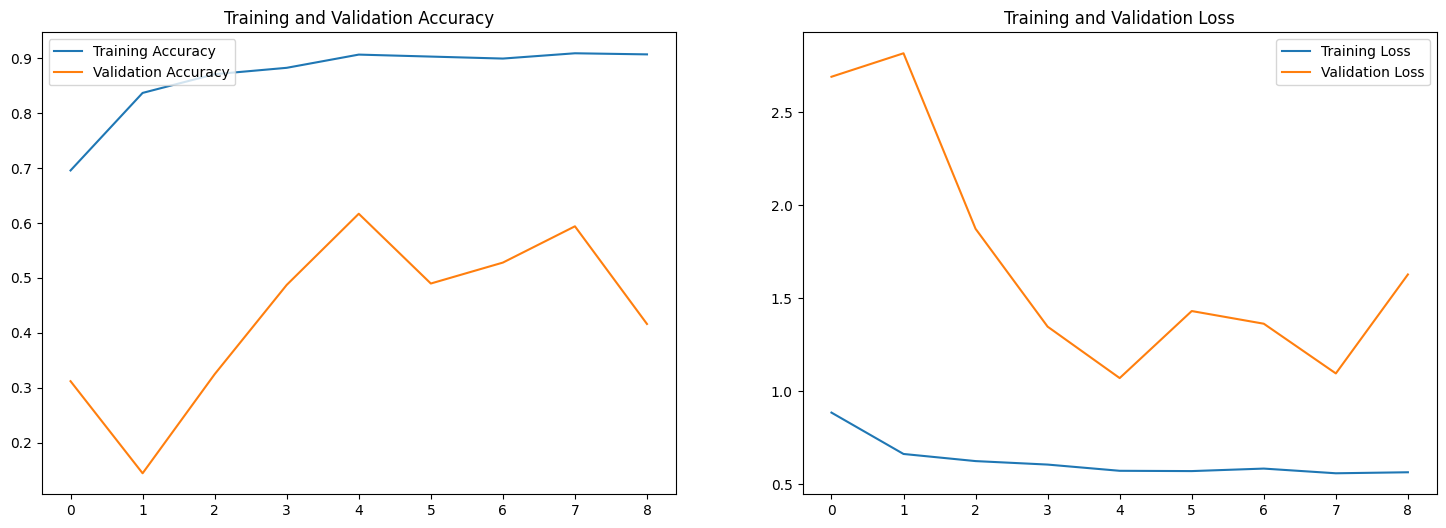

In [ ]:
# 4) Plot your training curves
plot_graphs(history_oversampled)

In [ ]:
improved.evaluate(testing_dataset, verbose=1)
predictions = improved.predict(testing_dataset, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4691 - loss: 1.6819
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


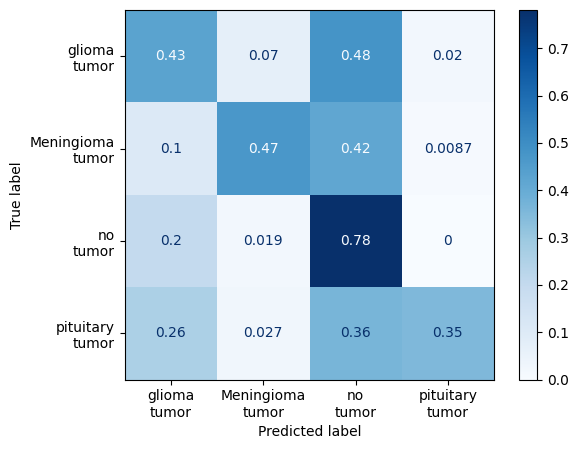

In [ ]:
pred = np.argmax(predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

In [ ]:
print(classification_report(testing_dataset.labels, pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.45      0.43      0.44       100
meningioma tumor       0.83      0.47      0.60       115
        no tumor       0.40      0.78      0.53       105
 pituitary tumor       0.90      0.35      0.50        74

        accuracy                           0.52       394
       macro avg       0.64      0.51      0.52       394
    weighted avg       0.63      0.52      0.52       394



In [ ]:
AUTOTUNE    = tf.data.AUTOTUNE
BATCH_SIZE  = training_dataset.batch_size

# 1) Turn your DirectoryIterator into a single-example tf.data stream
ds = tf.data.Dataset.from_generator(
    lambda: training_dataset,
    output_signature=(
      tf.TensorSpec((None,128,128,1), tf.float32),
      tf.TensorSpec((None,4),         tf.float32),
    )
).unbatch()

# 2) Split into four class-specific streams, shuffle each, then repeat
streams = []
for class_idx in range(4):
    s = (
      ds
      .filter(lambda img, label: tf.equal(tf.argmax(label, axis=-1), class_idx))
      .shuffle(500, seed=class_idx)  # shuffle within class
      .repeat()
    )
    streams.append(s)

# 3) Sample equally from all four streams
balanced_ds = tf.data.experimental.sample_from_datasets(
    streams,
    weights=[0.25, 0.25, 0.25, 0.25],
    seed=42
)

# 4) OPTIONAL: augment here
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.1, 0.2)
    return img, label

balanced_ds = (
    balanced_ds
      .map(augment, num_parallel_calls=AUTOTUNE)
      .shuffle(1000, seed=123)   # shuffle the mixed stream
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

# 5) Train with your callbacks & class_weights
history = improved.fit(
    balanced_ds,
    epochs=35,
    steps_per_epoch=len(training_dataset),  # 78
    validation_data=validation_dataset,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 410ms/step - accuracy: 0.7143 - loss: 0.9851 - val_accuracy: 0.2893 - val_loss: 5.5330 - learning_rate: 1.2500e-04
Epoch 2/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 393ms/step - accuracy: 0.8591 - loss: 0.6836 - val_accuracy: 0.3020 - val_loss: 3.1271 - learning_rate: 1.2500e-04
Epoch 3/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 385ms/step - accuracy: 0.8807 - loss: 0.6597 - val_accuracy: 0.3122 - val_loss: 3.8317 - learning_rate: 1.2500e-04
Epoch 4/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 360ms/step - accuracy: 0.8989 - loss: 0.6412 - val_accuracy: 0.3096 - val_loss: 3.3864 - learning_rate: 1.2500e-04
Epoch 5/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 376ms/step - accuracy: 0.8836 - loss: 0.6517 - val_accuracy: 0.3173 - val_loss: 3.8949 - learning_rate: 1.2500e-04
Epoch 6/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 377ms/step - accuracy: 0.8975 - loss: 0.6261 - val_accuracy: 0.1980 - val_loss: 3.7485 - learning_rate: 1.2500e-04
Epoch 7/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 382ms/step - acc

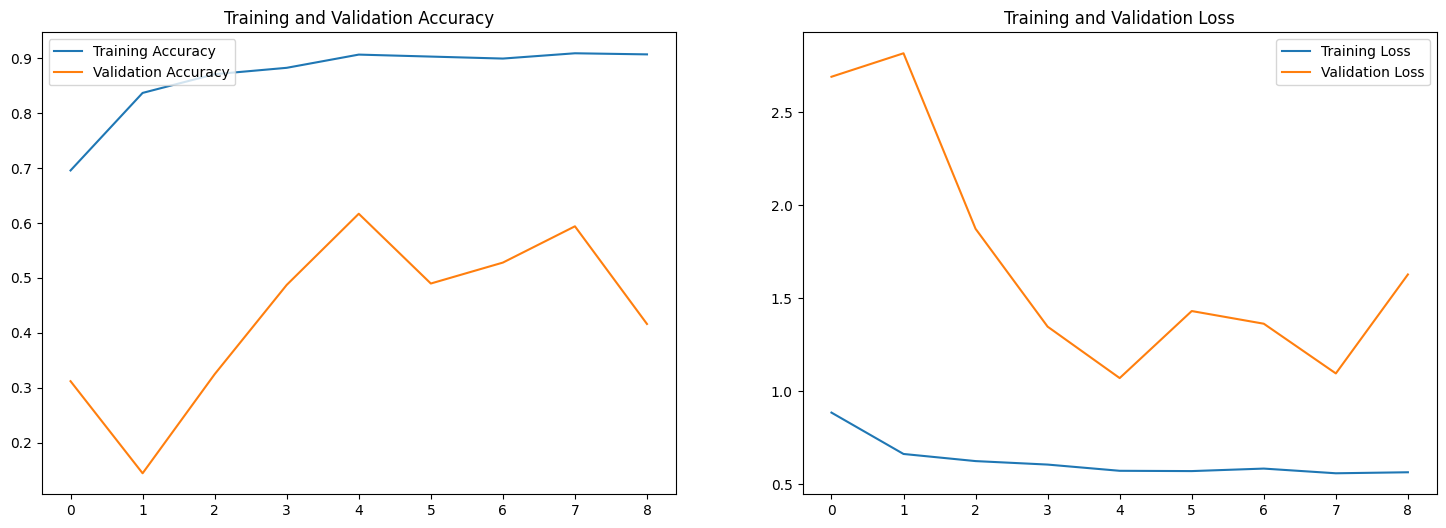

In [ ]:
# 4) Plot your training curves
plot_graphs(history_oversampled)

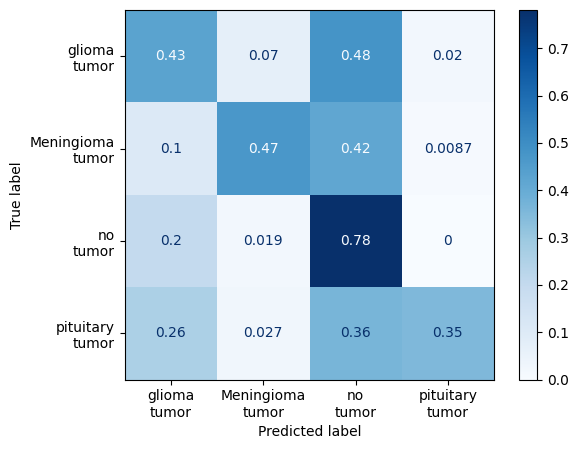

In [ ]:
pred = np.argmax(predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

--------------
# Transfert learning

In [ ]:
training_dataset = train_datagen.flow_from_directory('Training_cropped/',
                                                     target_size=(128,128),
                                                     color_mode="rgb",
                                                     subset="training",
                                                     class_mode='categorical',
                                                     shuffle = True)

validation_dataset = train_datagen.flow_from_directory('Training_cropped/',
                                                       target_size=(128,128),
                                                       color_mode="rgb",
                                                       subset="validation",
                                                       class_mode='categorical',
                                                       shuffle = True)

testing_dataset = test_datagen.flow_from_directory('Testing_cropped/',
                                                   target_size=(128,128),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   shuffle = False)

Found 2476 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


---------
## MobileNet

In [40]:
# 1) Load the MobileNet backbone without its top classification layers
MobileNet_input = MobileNet(
    include_top=False,    # exclude final Dense layers from ImageNet
    weights='imagenet',   # load pretrained ImageNet weights
    pooling='avg',        # global average pool to get a feature vector
    input_shape=(128,128,3),  # expect 128×128 RGB images
    classes=4             # number of output classes (not used when include_top=False)
)

# 2) Freeze the backbone so its pretrained weights are not updated during initial training
MobileNet_input.trainable = False

# 3) Attach a new head on top of the frozen backbone
MobileNet_top = MobileNet_input.output
MobileNet_top = Dense(units=1024, activation='relu')(MobileNet_top)  # hidden dense layer
out = Dense(units=4, activation='softmax')(MobileNet_top)           # output layer for 4 classes

# 4) Build the full model
my_MobileNet = Model(inputs=MobileNet_input.input, outputs=out)

# 5) Compile with Adam optimizer and categorical crossentropy loss
#    Tracking accuracy as the main metric
my_MobileNet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6) Display a summary of the model architecture and parameter counts
my_MobileNet.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,282,564 (16.34 MB)

 Trainable params: 1,053,700 (4.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


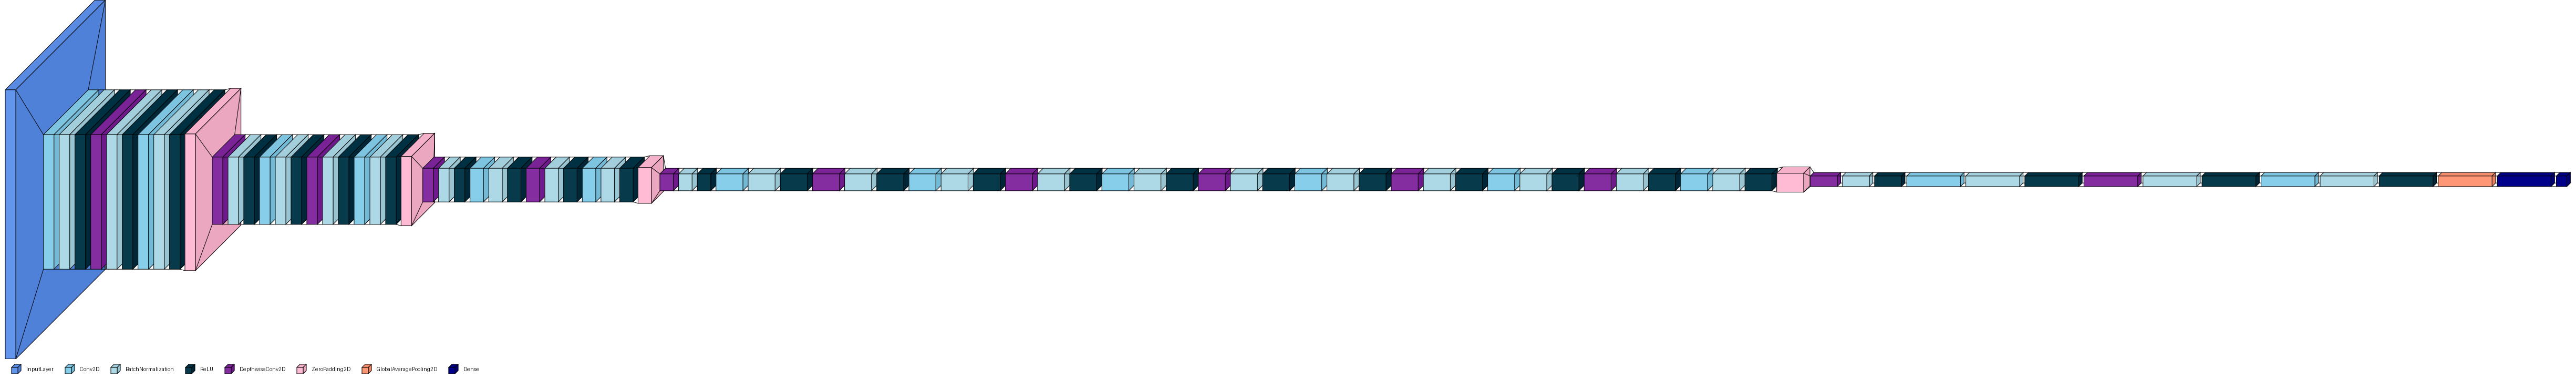

In [41]:
visualkeras.layered_view(my_MobileNet, legend=True, color_map=color_map)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 269ms/step - accuracy: 0.5884 - loss: 1.3273 - val_accuracy: 0.7411 - val_loss: 0.6579 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.8422 - loss: 0.4052 - val_accuracy: 0.8299 - val_loss: 0.4624 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.8500 - loss: 0.3729 - val_accuracy: 0.8122 - val_loss: 0.4508 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.8707 - loss: 0.3144 - val_accuracy: 0.8553 - val_loss: 0.4627 - learning_rate: 0.0010
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.8733 - loss: 0.2944 - val_accuracy: 0.8376 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8879 - loss: 0.2841
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.8879 - loss: 0.28

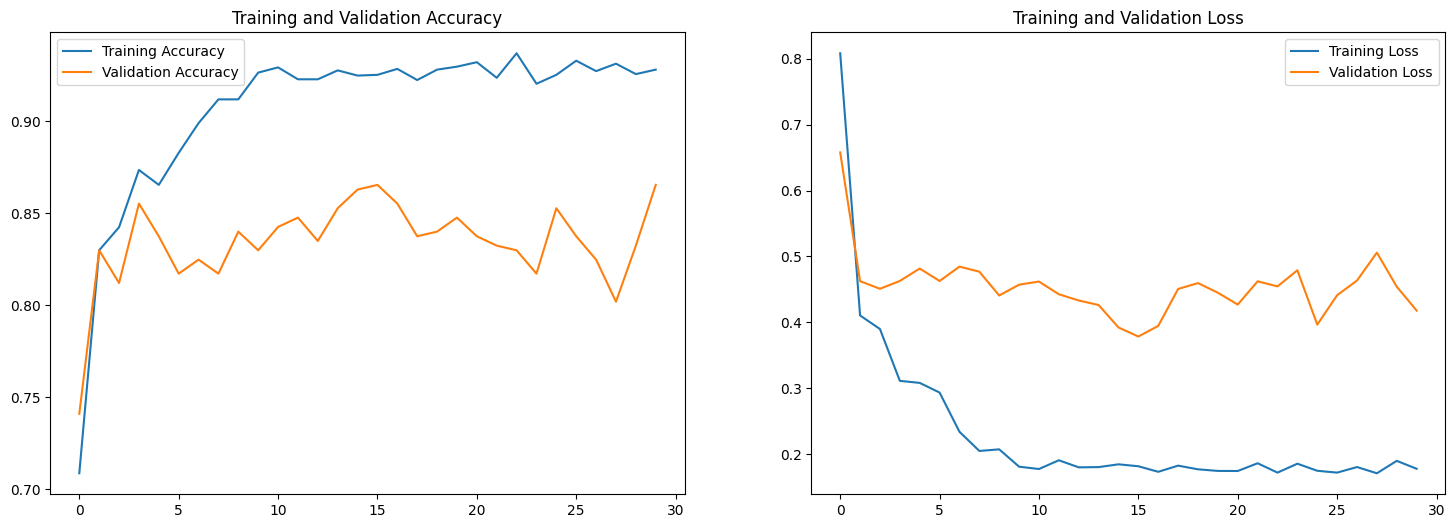

In [ ]:
callbacks_MobileNet = [ EarlyStopping(patience = 10,
                            monitor = "accuracy",
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy',
                                   factor = 0.3, patience = 2,
                                   min_delta = 0.001,
                                   mode='auto',verbose=1) ]

history_my_MobileNet = my_MobileNet.fit(
    training_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_mobilenet,
    class_weight=class_weights    )
plot_graphs(history_my_MobileNet)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5399 - loss: 2.1089
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step


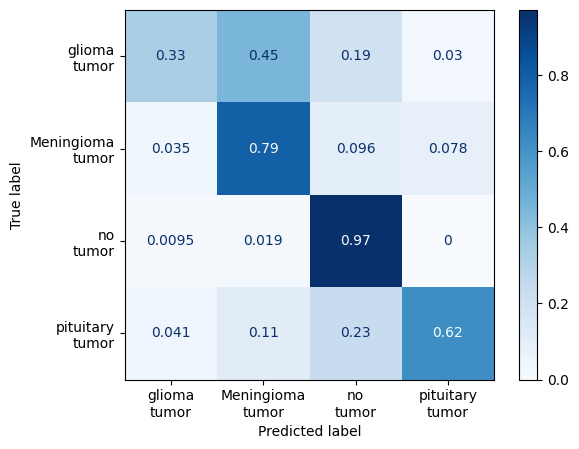

In [ ]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

In [ ]:
print(classification_report(testing_dataset.labels, pred_MobileNet, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.86      0.30      0.44       100
meningioma tumor       0.58      0.82      0.68       115
        no tumor       0.71      0.92      0.80       105
 pituitary tumor       0.76      0.64      0.69        74

        accuracy                           0.68       394
       macro avg       0.73      0.67      0.66       394
    weighted avg       0.72      0.68      0.66       394



##ConvNeXt-Tiny

In [ ]:
# 1) Load the ConvNeXt-Tiny backbone, without its top, pooling via global average
convnext_input = ConvNeXtTiny(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(128, 128, 3)
)
convnext_input.trainable = False

# 2) Attach your custom head
convnext_top = convnext_input.output
convnext_top = Dense(units=1024, activation="relu")(convnext_top)
convnext_top = BatchNormalization()(convnext_top)
convnext_top = Dropout(0.4)(convnext_top)
out = Dense(units=4, activation="softmax")(convnext_top)

# 3) Build the model
model_convnext = Model(inputs=convnext_input.input, outputs=out)

# 4) Compile
model_convnext.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 5) Inspect
model_convnext.summary()


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 128, 128,  │          0 │ input_layer_8[0]… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 32, 32,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 32, 32,    │         96 │ convnext_tiny_st

 Total params: 28,615,780 (109.16 MB)

 Trainable params: 793,604 (3.03 MB)

 Non-trainable params: 27,822,176 (106.13 MB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


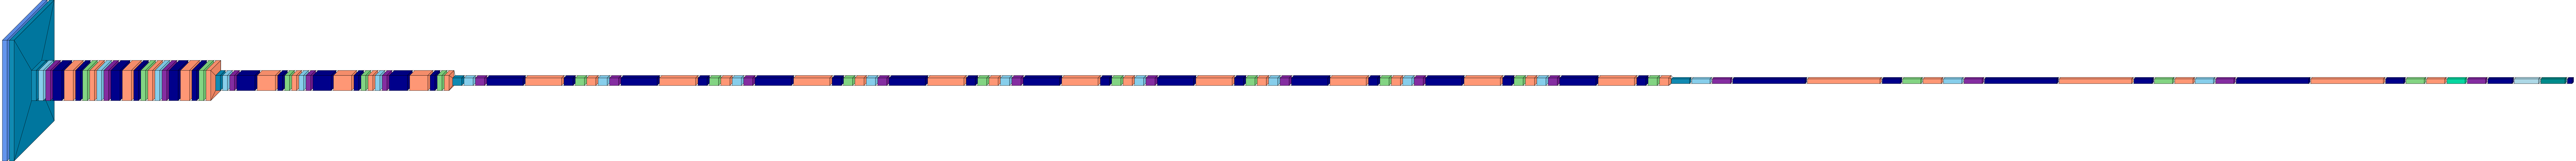

In [ ]:
# Visualize the ConvNeXt-Tiny–based model
visualkeras.layered_view(
    model_convnext,
    legend=False,
    color_map=color_map
)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.5845 - loss: 0.9888 - val_accuracy: 0.4112 - val_loss: 1.2655 - learning_rate: 7.2900e-07
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 0.6021 - loss: 0.9563 - val_accuracy: 0.4239 - val_loss: 1.2630 - learning_rate: 7.2900e-07
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.5696 - loss: 0.9963 - val_accuracy: 0.4340 - val_loss: 1.2228 - learning_rate: 7.2900e-07
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.5890 - loss: 0.9530 - val_accuracy: 0.3934 - val_loss: 1.2343 - learning_rate: 7.2900e-07
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5780 - loss: 0.9516
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.5782 - loss: 0.9515 - val_accuracy: 0.4188 - val_loss: 1.2281 - learning_rate: 7.2900e-07
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy

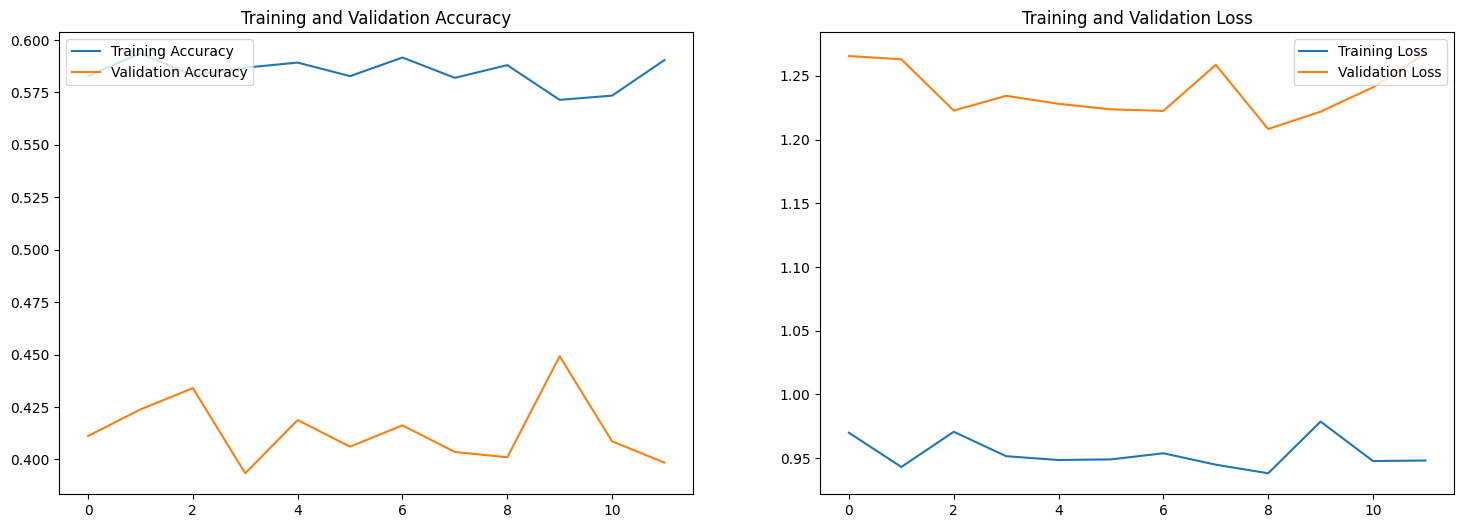

In [ ]:
# 1) Define callbacks for ConvNeXt-Tiny (same settings as VGG16)
callbacks_cnx = [
    EarlyStopping(
        patience=10,
        monitor="accuracy",
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=2,
        min_delta=0.001,
        mode='auto',
        verbose=1
    )
]

# 2) Train ConvNeXt-Tiny with class weights
history_cnx = model_convnext.fit(
    training_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_cnx,
    class_weight=class_weights    # ← add this argument
)

# 3) Plot training & validation curves
plot_graphs(history_cnx)



In [ ]:
# 1) Evaluate on the test set
model_convnext.evaluate(testing_dataset, verbose=1)

# 2) Get predictions
predictions_cnx = model_convnext.predict(testing_dataset, verbose=1)
pred_cnx = np.argmax(predictions_cnx, axis=1)

# 3) Plot the normalized confusion matrix

ConfusionMatrixDisplay.from_predictions(
    testing_dataset.classes,
    pred_cnx,
    display_labels=['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
    cmap='Blues',
    normalize='true'
)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3506 - loss: 2.4738
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [ ]:
# Print classification report for ConvNeXt-Tiny
print(classification_report(
    testing_dataset.classes,
    pred_cnx,
    target_names=target_names
))



                  precision    recall  f1-score   support

    glioma tumor       0.35      0.22      0.27       100
meningioma tumor       0.58      0.57      0.57       115
        no tumor       0.38      0.51      0.44       105
 pituitary tumor       0.28      0.28      0.28        74

        accuracy                           0.41       394
       macro avg       0.40      0.40      0.39       394
    weighted avg       0.41      0.41      0.40       394



##EfficientNetB0

In [ ]:
# 1) Load the EfficientNetB0 backbone, without its top, pooling via global average
effb0_base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(128, 128, 3)
)
effb0_base.trainable = False    # freeze the pretrained weights

# 2) Attach your custom head
x = effb0_base.output
x = Dense(units=1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(units=4, activation="softmax")(x)

# 3) Build the model
model_effb0 = Model(inputs=effb0_base.input, outputs=outputs)

# 4) Compile
model_effb0.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_effb0.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 5,369,511 (20.48 MB)

 Trainable params: 1,317,892 (5.03 MB)

 Non-trainable params: 4,051,619 (15.46 MB)

In [ ]:
# Visualize the EfficientNetB0-based model
visualkeras.layered_view(
    model_effb0,
    legend=False,
    color_map=color_map
)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
# 1) Define the callbacks
callbacks_effb0 = [
    EarlyStopping(
        patience=10,
        monitor="val_accuracy",
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.3,
        patience=2,
        min_delta=0.001,
        mode="auto",
        verbose=1
    )
]

# 2) Train the EfficientNetB0 model
history_effb0 = model_effb0.fit(
    training_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_effb0,
    class_weight=class_weights    # if you want to keep using class weights
)

# 3) Plot the training curves
plot_graphs(history_effb0)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 54s 398ms/step - accuracy: 0.2599 - loss: 1.8619 - val_accuracy: 0.2893 - val_loss: 1.3924 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.2642 - loss: 1.5450 - val_accuracy: 0.1827 - val_loss: 1.5299 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2574 - loss: 1.5257
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.2575 - loss: 1.5254 - val_accuracy: 0.1675 - val_loss: 1.6573 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.2734 - loss: 1.4986 - val_accuracy: 0.1371 - val_loss: 1.5273 - learning_rate: 3.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3167 - loss: 1.4538
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.3165 - loss: 1.4538 - v

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3239 - loss: 1.4193
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step


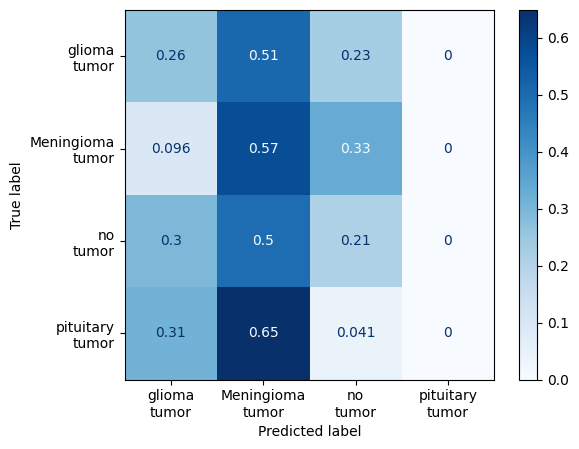

In [ ]:
# 1) Evaluate on the test set
model_effb0.evaluate(testing_dataset, verbose=1)

# 2) Get predictions
predictions_effb0 = model_effb0.predict(testing_dataset, verbose=1)
pred_effb0 = np.argmax(predictions_effb0, axis=1)

# 3) Plot the normalized confusion matrix
ConfusionMatrixDisplay.from_predictions(
    testing_dataset.classes,
    pred_effb0,
    display_labels=['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
    cmap='Blues',
    normalize='true'
)


In [ ]:
# Print the classification report for EfficientNetB0
print(classification_report(
    testing_dataset.labels,
    pred_effb0,
    target_names=target_names
))


                  precision    recall  f1-score   support

    glioma tumor       0.29      0.26      0.27       100
meningioma tumor       0.30      0.57      0.40       115
        no tumor       0.26      0.21      0.23       105
 pituitary tumor       0.00      0.00      0.00        74

        accuracy                           0.29       394
       macro avg       0.21      0.26      0.23       394
    weighted avg       0.23      0.29      0.25       394



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------
## DenseNet121

In [ ]:
DenseNet_input = DenseNet121(include_top=False,
                             weights='imagenet',
                             pooling = 'avg',
                             input_shape=(128,128, 3),
                             classes = 4)

DenseNet_input.trainable = False

DenseNet_top = DenseNet_input.output
DenseNet_top = Dense(units = 1024, activation = "relu")(DenseNet_top)
out = Dense(units = 4, activation = "softmax")(DenseNet_top)

my_DenseNet = Model(inputs = DenseNet_input.input, outputs = out)

my_DenseNet.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

my_DenseNet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 8,091,204 (30.87 MB)

 Trainable params: 1,053,700 (4.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


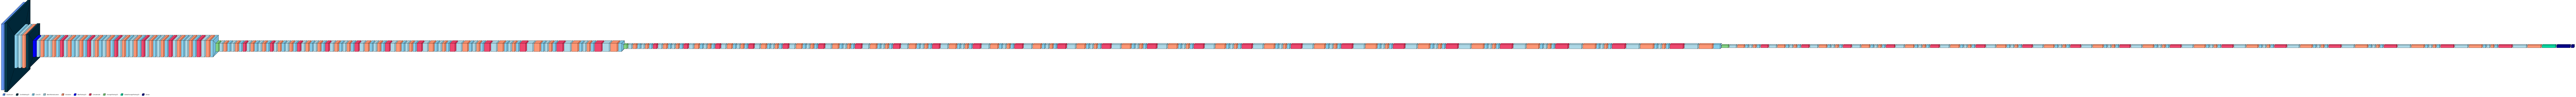

In [ ]:
visualkeras.layered_view(my_DenseNet, legend=True, color_map=color_map)

In [ ]:
callbacks_DenseNet = [ EarlyStopping(patience = 10,
                            monitor = "accuracy",
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy',
                                   factor = 0.3, patience = 2,
                                   min_delta = 0.001,
                                   mode='auto',verbose=1) ]

# 2) Train DenseNet with class weights
history_my_DenseNet = my_DenseNet.fit(
    training_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_DenseNet,
    class_weight=class_weights    # ← include your computed class weights here
)

# 3) Plot training & validation curves
plot_graphs(history_my_DenseNet)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 72s 593ms/step - accuracy: 0.5695 - loss: 1.4114 - val_accuracy: 0.7310 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.7857 - loss: 0.5102 - val_accuracy: 0.7741 - val_loss: 0.5568 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.7987 - loss: 0.4816 - val_accuracy: 0.7208 - val_loss: 0.8293 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.8182 - loss: 0.4633 - val_accuracy: 0.7893 - val_loss: 0.5971 - learning_rate: 0.0010
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - accuracy: 0.8130 - loss: 0.4770 - val_accuracy: 0.7284 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8268 - loss: 0.4108
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.8269 - loss: 0.41

In [ ]:
my_DenseNet.evaluate(testing_dataset, verbose=1)
predictions_DenseNet = my_DenseNet.predict(testing_dataset, verbose=1)
pred_DenseNet = np.argmax(predictions_DenseNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_DenseNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4926 - loss: 1.9618
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 915ms/step


In [ ]:
print(classification_report(testing_dataset.labels, pred_DenseNet, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.74      0.28      0.41       100
meningioma tumor       0.61      0.71      0.66       115
        no tumor       0.64      0.93      0.76       105
 pituitary tumor       0.62      0.58      0.60        74

        accuracy                           0.64       394
       macro avg       0.65      0.63      0.61       394
    weighted avg       0.65      0.64      0.61       394



--------
## VGG 16

In [ ]:
vgg16_input = VGG16(include_top=False,
                     weights = 'imagenet',
                     pooling = 'avg',
                     input_shape = (128,128, 3),
                     classes = 4)

vgg16_input.trainable = False

vgg16_top = vgg16_input.output
vgg16_top = Dense(units = 1024, activation = "relu")(vgg16_top)
vgg16_top = BatchNormalization()(vgg16_top)
vgg16_top = Dropout(0.4)(vgg16_top)
out = Dense(units = 4, activation = "softmax")(vgg16_top)

my_vgg16 = Model(inputs = vgg16_input.input, outputs = out)


my_vgg16.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

my_vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │         4,10

 Total params: 15,248,196 (58.17 MB)

 Trainable params: 531,460 (2.03 MB)

 Non-trainable params: 14,716,736 (56.14 MB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


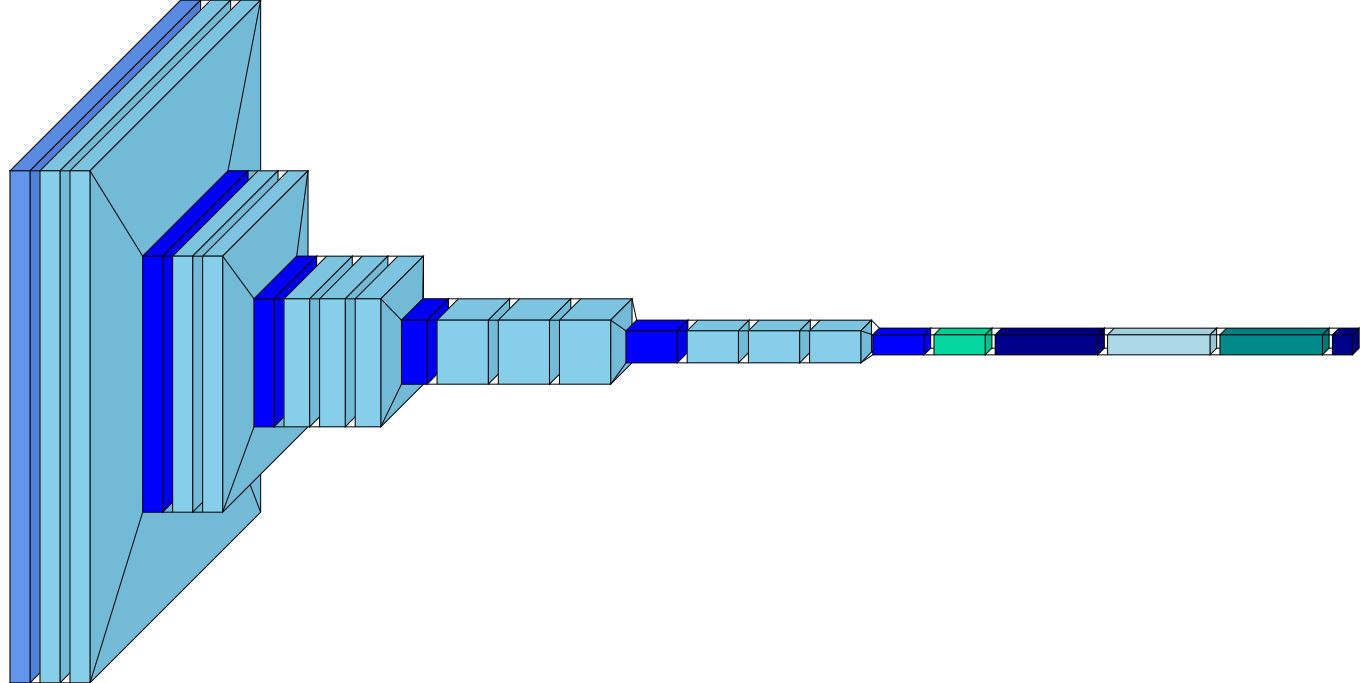

In [ ]:
visualkeras.layered_view(my_vgg16, legend=False, color_map=color_map)

In [ ]:
# 1) Define your callbacks as before
callbacks_vgg = [
    EarlyStopping(
        patience=10,
        monitor="accuracy",
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=2,
        min_delta=0.001,
        mode='auto',
        verbose=1
    )
]

# 2) Train VGG16 with class weights
history_my_vgg16 = my_vgg16.fit(
    training_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_vgg,
    class_weight=class_weights    # ← include your class weights here
)

# 3) Plot the training & validation curves
plot_graphs(history_my_vgg16)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - accuracy: 0.5700 - loss: 1.1589 - val_accuracy: 0.5812 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.7290 - loss: 0.6727 - val_accuracy: 0.4162 - val_loss: 1.1419 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7270 - loss: 0.6924
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.7270 - loss: 0.6923 - val_accuracy: 0.5178 - val_loss: 0.9720 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.7720 - loss: 0.5729 - val_accuracy: 0.6015 - val_loss: 0.8631 - learning_rate: 3.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.7743 - loss: 0.5532 - val_accuracy: 0.6650 - val_loss: 0.7495 - learning_rate: 3.0000e-04
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.7529 - lo

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4053 - loss: 3.0517
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step


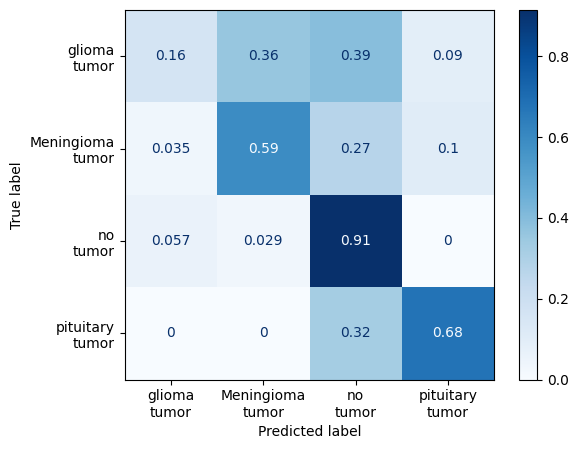

In [ ]:
my_vgg16.evaluate(testing_dataset, verbose=1)
predictions_vgg = my_vgg16.predict(testing_dataset, verbose=1)
pred_vgg = np.argmax(predictions_vgg, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_vgg,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

In [ ]:
print(classification_report(testing_dataset.labels, pred_vgg, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.64      0.23      0.34       100
meningioma tumor       0.61      0.65      0.63       115
        no tumor       0.56      0.87      0.68       105
 pituitary tumor       0.63      0.62      0.63        74

        accuracy                           0.60       394
       macro avg       0.61      0.59      0.57       394
    weighted avg       0.61      0.60      0.57       394



## Mobinet improved

In [42]:
callbacks_MobileNet = [ EarlyStopping(patience = 10,
                            monitor = "accuracy",
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy',
                                   factor = 0.3, patience = 2,
                                   min_delta = 0.001,
                                   mode='auto',verbose=1) ]

history_my_MobileNet = my_MobileNet.fit(
    training_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_MobileNet,
    class_weight=class_weights    )
plot_graphs(history_my_MobileNet)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.6303 - loss: 1.2824 - val_accuracy: 0.7716 - val_loss: 0.6020 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.8651 - loss: 0.3481 - val_accuracy: 0.7970 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8907 - loss: 0.2816 - val_accuracy: 0.8325 - val_loss: 0.5117 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.9111 - loss: 0.2101 - val_accuracy: 0.8274 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9167 - loss: 0.2152
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.9165 - loss: 0.2158 - val_accuracy: 0.7589 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.9109 - loss: 0.20

In [43]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6004 - loss: 2.1675
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step


### Selective Top-Layer Fine-Tuning of MobileNet for Brain Tumor MRI Classification


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - accuracy: 0.6014 - loss: 1.3531 - val_accuracy: 0.8299 - val_loss: 0.5546 - learning_rate: 1.0000e-05
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.8306 - loss: 0.4116 - val_accuracy: 0.8096 - val_loss: 0.5940 - learning_rate: 1.0000e-05
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8470 - loss: 0.3592
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.8472 - loss: 0.3591 - val_accuracy: 0.8223 - val_loss: 0.5759 - learning_rate: 1.0000e-05
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.8805 - loss: 0.2736 - val_accuracy: 0.8249 - val_loss: 0.5058 - learning_rate: 3.0000e-06
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8777 - loss: 0.3001
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999636216671e-07.
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.87

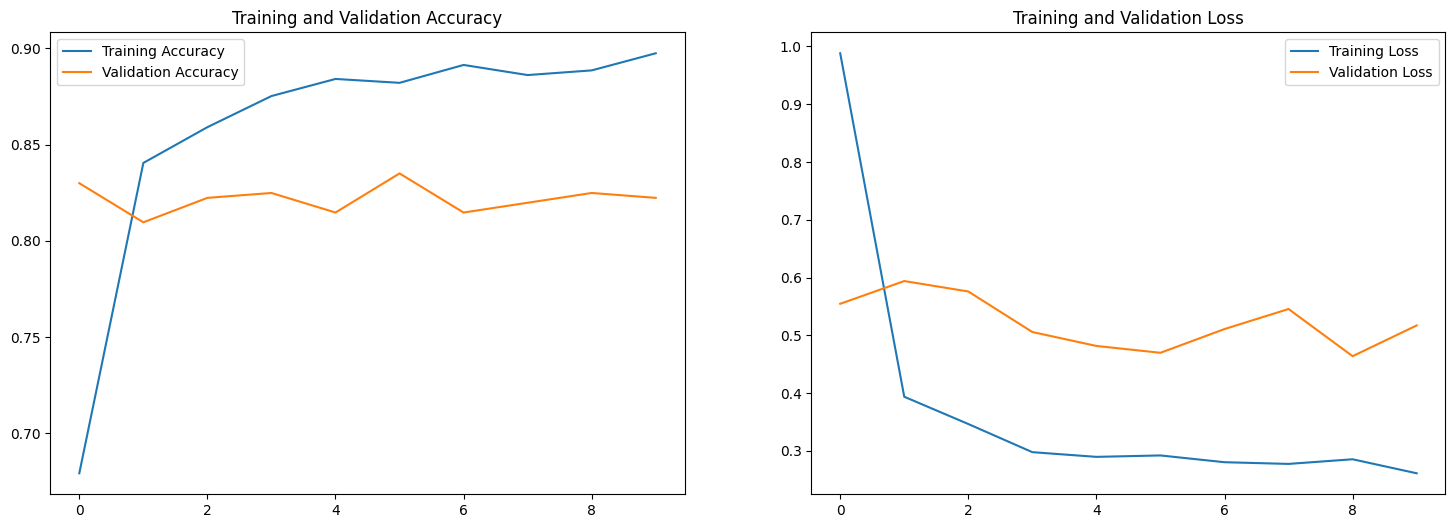

In [25]:
# 1. Unfreeze the last N layers of the MobileNet backbone so they can be fine-tuned
N = 20  # number of top layers to unfreeze; adjust based on model depth and dataset size
for layer in my_MobileNet.layers[-N:]:
    layer.trainable = True  # allow gradient updates on these layers

# 2. Re-compile the model with a very low learning rate to softly adjust pretrained weights
my_MobileNet.compile(
    optimizer=Adam(1e-5),               # tiny learning rate for fine-tuning
    loss="categorical_crossentropy",    # appropriate for one-hot 4-class classification
    metrics=["accuracy"]                # track accuracy on train/validation
)

# 3. Continue training for a few more epochs to adapt the top layers to MRI-specific patterns
fine_tune_history = my_MobileNet.fit(
    training_dataset,            # original training generator
    validation_data=validation_dataset,  # original validation generator
    epochs=10,                   # fewer epochs to avoid over-fitting
    callbacks=callbacks_MobileNet,   # same early-stop & LR scheduler as before
    class_weight=class_weights       # still weight classes to balance glioma emphasis
)

# 4. Plot the training and validation curves to observe any performance lift
plot_graphs(fine_tune_history)



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5238 - loss: 2.5181
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step


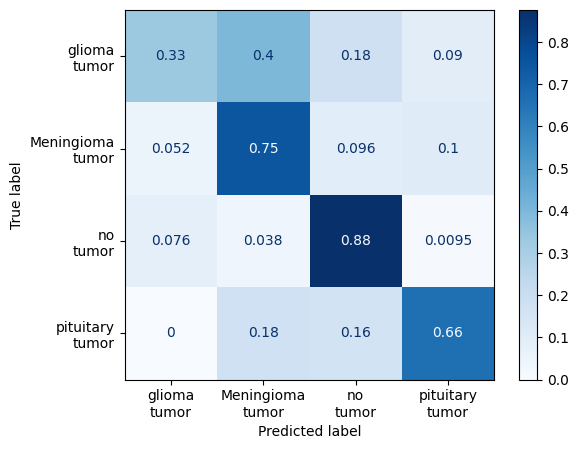

In [26]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

### Two-Stage Progressive Fine-Tuning of MobileNet with Head Training and Last-Block Unfreezing









Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.9509 - loss: 0.1546 - val_accuracy: 0.8503 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.9404 - loss: 0.1635 - val_accuracy: 0.8452 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9238 - loss: 0.1628
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.9238 - loss: 0.1629 - val_accuracy: 0.8299 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.9242 - loss: 0.1779 - val_accuracy: 0.8477 - val_loss: 0.4391 - learning_rate: 3.0000e-04
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.9307 - loss: 0.1687 - val_accuracy: 0.8579 - val_loss: 0.4110 - learning_rate: 3.0000e-04
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step - accuracy: 0.4570 - loss: 1.8631 - va

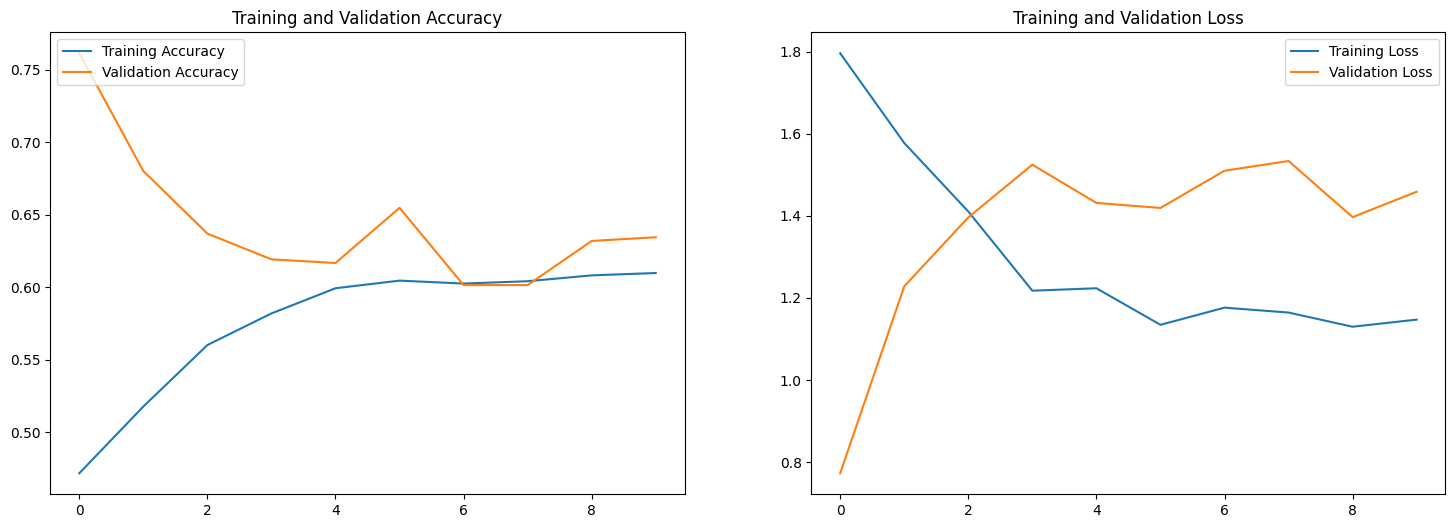

In [33]:
# 1) Head-only: freeze everything, train head
for layer in my_MobileNet.layers:
    layer.trainable = False

# (Re-compile and train for 5 epochs)
my_MobileNet.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
my_MobileNet.fit(
    training_dataset, validation_data=validation_dataset,
    epochs=5, callbacks=callbacks_MobileNet, class_weight=class_weights
)

# 2) Unfreeze only the *last* Conv block (e.g. last 8 layers)
for layer in my_MobileNet.layers[-8:]:
    layer.trainable = True

# 3) Re-compile with a tiny LR
my_MobileNet.compile(
    optimizer=Adam(1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4) Continue training for 5–10 epochs
fine_tune_history = my_MobileNet.fit(
    training_dataset, validation_data=validation_dataset,
    epochs=10, callbacks=callbacks_MobileNet, class_weight=class_weights
)
plot_graphs(fine_tune_history)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3586 - loss: 4.7424
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step


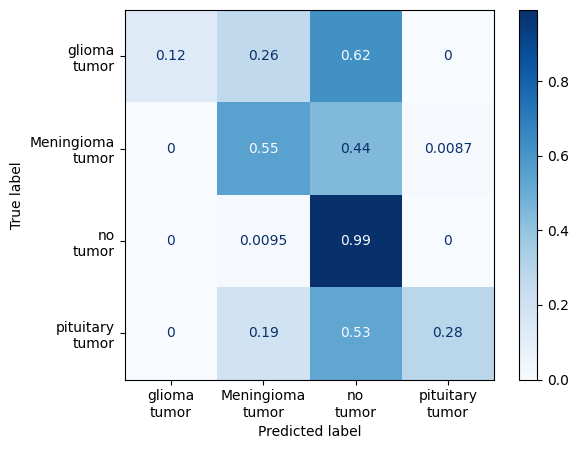

In [34]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

### Head-Only Training of a Frozen MobileNet Backbone with Data Augmentation









In [24]:
x = MobileNet_input.output
x = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation="softmax")(x)
my_MobileNet = Model(MobileNet_input.input, outputs)


In [25]:
callbacks_MobileNet = [
  EarlyStopping(patience=10, monitor="val_accuracy", restore_best_weights=True),
  ReduceLROnPlateau(monitor="val_accuracy", factor=0.3, patience=2, min_delta=0.001, verbose=1)
]


Found 2476 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
input_layer_3 False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
co

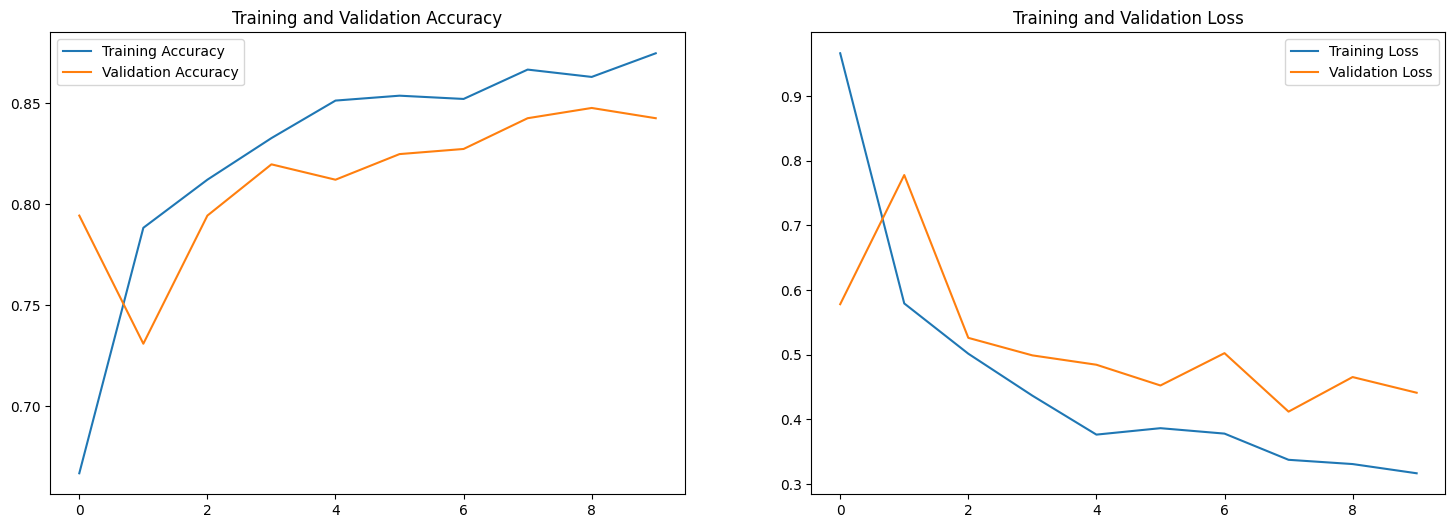

In [28]:
# 0) Data generators (unchanged)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.138
)
training_dataset = train_datagen.flow_from_directory(
    'Training_cropped/',
    target_size=(128,128),
    color_mode='rgb',
    subset='training',
    class_mode='categorical',
    shuffle=True,
    batch_size=32
)
validation_dataset = train_datagen.flow_from_directory(
    'Training_cropped/',
    target_size=(128,128),
    color_mode='rgb',
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    batch_size=32
)

# 1) Rebuild your MobileNet + head, but freeze only the backbone
backbone = MobileNet(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(128,128,3)
)
backbone.trainable = False   # freeze only these layers

x = backbone.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

my_MobileNet = Model(inputs=backbone.input, outputs=outputs)

# 2) Check that ONLY the head is trainable
for layer in my_MobileNet.layers:
    print(layer.name, layer.trainable)
# You should see backbone layers = False, Dense/BN/Dropout = True

# 3) Compile & fit just the head
callbacks_head = [
    EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2,
                      min_delta=0.001, mode='auto', verbose=1),
]
my_MobileNet.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_head = my_MobileNet.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks_head,
    class_weight=class_weights
)
plot_graphs(history_head)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5844 - loss: 2.0275
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


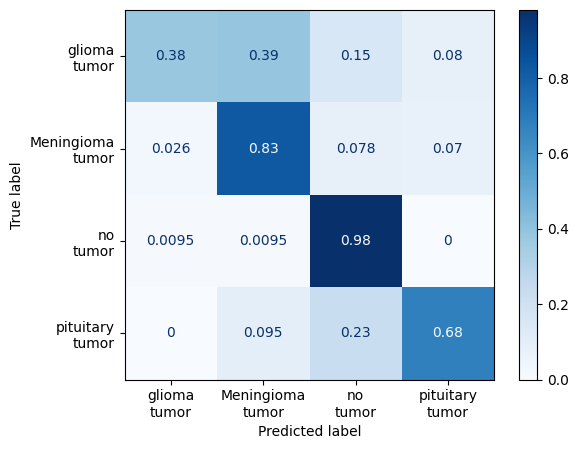

In [31]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

### Selective Fine-Tuning of Top 6 Layers with Low Learning Rate

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.8307 - loss: 0.5025 - val_accuracy: 0.8046 - val_loss: 0.6501 - learning_rate: 1.0000e-06
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.8490 - loss: 0.4596 - val_accuracy: 0.7944 - val_loss: 0.8150 - learning_rate: 1.0000e-06
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8684 - loss: 0.3414
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.999999992425728e-07.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.8684 - loss: 0.3416 - val_accuracy: 0.7538 - val_loss: 0.8564 - learning_rate: 1.0000e-06
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.8682 - loss: 0.3500 - val_accuracy: 0.7513 - val_loss: 0.9599 - learning_rate: 3.0000e-07
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8656 - loss: 0.3465
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000318337698e-08.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.865

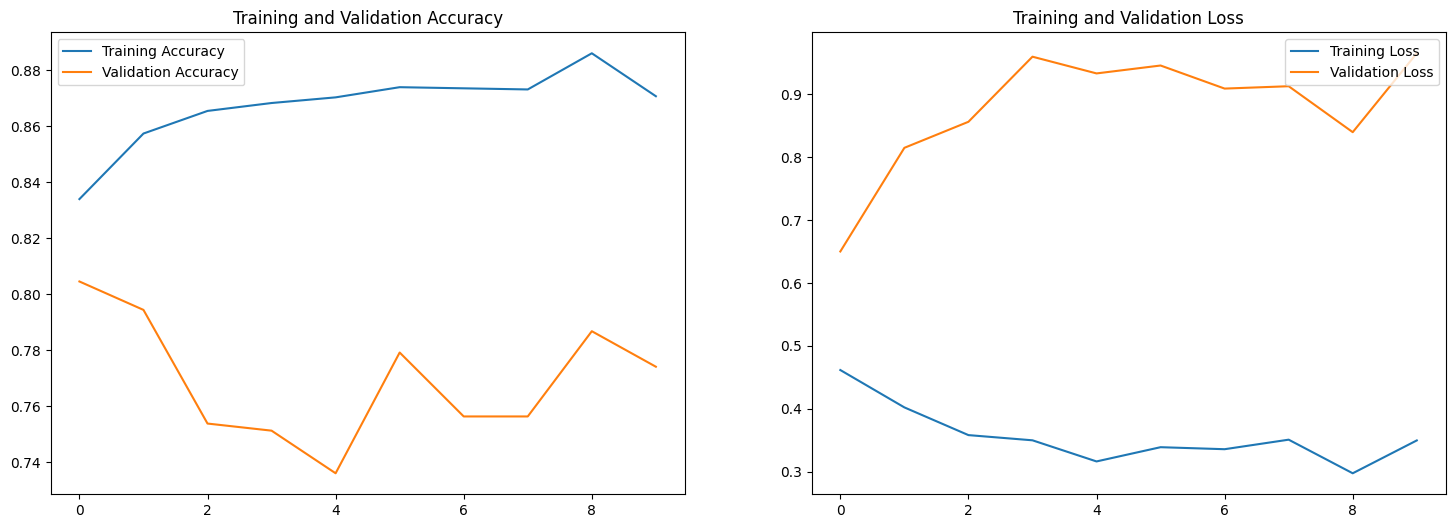

In [38]:
# 1) Unfreeze the top 6 layers (for example)
for layer in my_MobileNet.layers[-6:]:
    layer.trainable = True

# 2) Re-compile with a tiny LR so we only 'nudge' those weights
my_MobileNet.compile(
    optimizer=Adam(1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Fine-tune for 5–10 more epochs
fine_tune_hist = my_MobileNet.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks_head,      # same EarlyStopping/RLROP setup
    class_weight=class_weights
)

plot_graphs(fine_tune_hist)


In [39]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5391 - loss: 3.3034
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step


### Ultra-Fine Tuning of Final 3 Convolutional Layers with Micro Learning Rate

Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.9664 - loss: 0.0929 - val_accuracy: 0.8756 - val_loss: 0.3577 - learning_rate: 5.0000e-07
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.9571 - loss: 0.0997 - val_accuracy: 0.8756 - val_loss: 0.3647 - learning_rate: 5.0000e-07
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9591 - loss: 0.1073
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.499999996212864e-07.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.9591 - loss: 0.1071 - val_accuracy: 0.8376 - val_loss: 0.4339 - learning_rate: 5.0000e-07
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9642 - loss: 0.0932 - val_accuracy: 0.8528 - val_loss: 0.4072 - learning_rate: 1.5000e-07
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9625 - loss: 0.0898
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.500000159168849e-08.
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.9626 - l

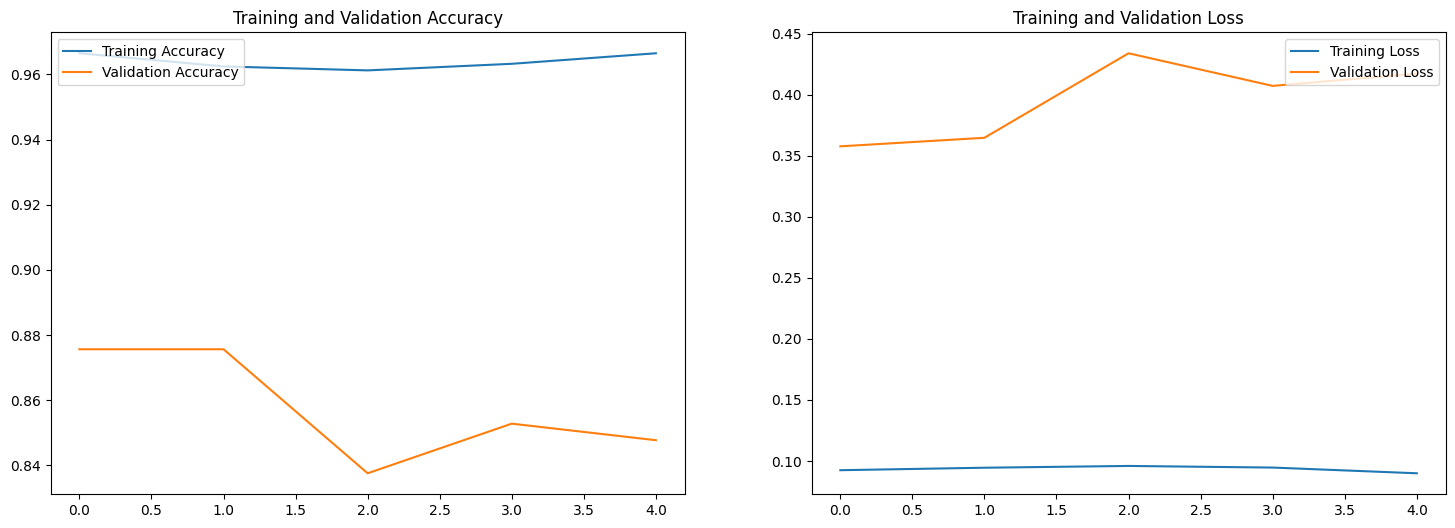

In [44]:
# 1) Unfreeze only the *last 3* conv layers
for layer in my_MobileNet.layers[-3:]:
    layer.trainable = True

# 2) Re-compile at an even smaller LR
my_MobileNet.compile(
    optimizer=Adam(5e-7),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Fine-tune for just 3–5 epochs
ft_hist = my_MobileNet.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=callbacks_head,
    class_weight=class_weights
)
plot_graphs(ft_hist)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6004 - loss: 2.1686
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step


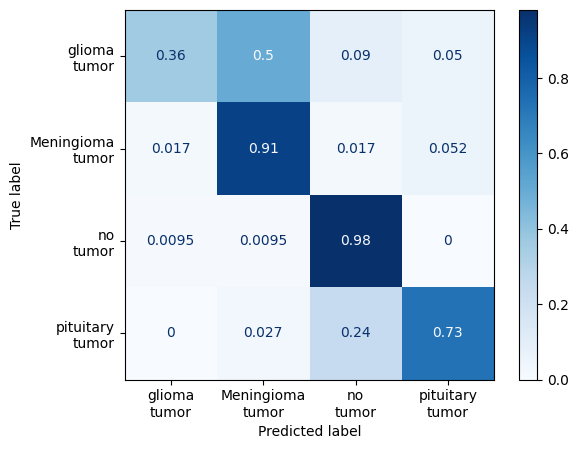

In [45]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet,
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'],
                                        cmap='Blues', normalize = 'true')